In [11]:
from tensorflow import keras

import os
import tempfile
import csv

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from decimal import *

import pandas as pd

from datetime import datetime

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense,Dropout, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Reshape


import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures

from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle



In [12]:

def load_csv(url_data, separator):
    file = tf.keras.utils
    custom_date_parser = lambda x: datetime.strptime(x, "%Y.%m.%d_%H:%M:%S_TAI") 
    raw_df = pd.read_csv(url_data, sep=separator,parse_dates=['T_REC'], date_parser=custom_date_parser)
    raw_df.head()
    
    return raw_df


def count_class(file):
    neg, pos = np.bincount(file['Class'])
    total = neg + pos
    print('Samples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
    return pos,neg
  

def select_columns(raw_df, list_col_delete):
    
    cleaned_df = raw_df.copy()

    for cd in list_col_delete:
        cleaned_df.pop(cd)

    return cleaned_df


def TSS_matrix_confusion(TN, FP, FN, TP):
    TSS = 0
    
    sensitivity = TP / (TP + FP)
    specificity = TN / (FN + TN)
    TSS = sensitivity + specificity - 1

    return TSS


def HSS_matrix_confusion(TN, FP, FN, TP):
    HSS = 0
    
    HSS = ( 2 * ((TP * TN) - (FN * FP)) ) / ( (TP + FN)* (FN + TN) + (TP + FN) * (FP + TN) )
    
    return HSS

def FAR_matrix_confusion(TN, FP, FN, TP):
    FAR = 0

    FAR = FP/(TP+FP)

    return FAR
    
def define_metrics():
        
    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='roc', curve = 'ROC'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    
    ]

    return METRICS


def normalization_scaler(train_features, val_features, test_features):
    #data normalization - sklearn StandardScaler - sets mean to 0 and standard deviation to 1
    scaler = StandardScaler()
    
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    train_features = np.clip(train_features, -5, 5)
    val_features = np.clip(val_features, -5, 5)
    test_features = np.clip(test_features, -5, 5)

    return train_features, val_features, test_features


def balancing_smote(cleaned_df):

    cleaned_df['T_REC'] = cleaned_df['T_REC'].apply(lambda x: x.value)
    X = cleaned_df.loc[:, cleaned_df.columns != 'Class']
    y = cleaned_df.Class
    sm = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=100)
    X_res, y_res = sm.fit_resample(X, y)
    cleaned_df = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
    cleaned_df['T_REC'] = cleaned_df['T_REC'].apply(pd.Timestamp)
    return cleaned_df
    
def balancing_undersampling(cleaned_df):

    pos_flare = cleaned_df[cleaned_df['Class']==1]
    neg_flare = cleaned_df[cleaned_df['Class']==0]
    neg_flare = neg_flare.sample(n=len(pos_flare), random_state=101)
    cleaned_df = pd.concat([pos_flare,neg_flare],axis=0)
    return cleaned_df
    
def balancing_oversampling(cleaned_df):
        
    neg, pos = np.bincount(cleaned_df['Class'])

    pos_flare = cleaned_df[cleaned_df['Class']==1]
    neg_flare = cleaned_df[cleaned_df['Class']==0]

    pos_flare = pos_flare.sample(n=len(neg_flare), random_state=101, replace = True)
    cleaned_df = pd.concat([pos_flare,neg_flare],axis=0)

    neg, pos = np.bincount(cleaned_df['Class'])

    return cleaned_df


#MLP model
def make_model(METRICS, train_features,output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    

    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                            bias_initializer=output_bias),
    ])


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS)
    
    return model


#LSTM model
def make_model_LSTM(METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential()
    model.add(LSTM(8,input_shape=(18,1),return_sequences=False))#True = many to many #numero colunas csv
    model.add(Dense(2,kernel_initializer='normal',activation='linear'))
    model.add(Dense(1,kernel_initializer='normal',activation='linear'))
    model.compile(loss='mse',optimizer ='adam',metrics=METRICS)

    return model


#SVM model
def make_model_SVM(METRICS,output_bias=None):
    model = keras.Sequential(
    [
        keras.Input(shape=(18,)), #number of fields in my csv
        RandomFourierFeatures(
            output_dim=4096, scale=10.0, kernel_initializer="gaussian"
        ),
        layers.Dense(units=1),
    ]
    )

        
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.hinge,
        metrics=METRICS,
    )
        
    return model



#Transformers model
def make_model_transformers(METRICS, features, output_bias=None):
    train_features = features[0]
    val_features = features[1]
    test_features = features[2]

    x_train  = train_features[:, 1:]
    x_val = val_features[:, 1:]
    x_test = test_features[:, 1:]

    y_train  = train_features[:, 0]
    y_val = val_features[:, 0]
    y_test = test_features[:, 0]

    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    y_test = y_test.astype(int)

    n_classes = len(np.unique(y_train))

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


    idx = np.random.permutation(len(x_train))
    x_train = x_train[idx]
    y_train = y_train[idx]


    y_train[y_train == -1] = 0
    y_val[y_val == -1] = 0
    y_test[y_test == -1] = 0


    input_shape = x_train.shape[1:]

    model = build_model_transformers(
        n_classes,
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

    callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
    
    y_train = y_train -1
    y_val = y_val -1
    y_test = y_test -1
    
    y_train = tf.keras.utils.to_categorical(y_train,num_classes = 6) #num_classes = 2
    y_val = tf.keras.utils.to_categorical(y_val, num_classes = 6)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes= 6)

    loss_function = "binary_crossentropy" 
  
    
    model.compile(
        loss=loss_function,
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics= METRICS
    )

    conj_x_y = [x_train, y_train, x_val, y_val, x_test, y_test]


    return model, conj_x_y, callbacks



def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

#https://keras.io/examples/timeseries/timeseries_classification_transformer/
def build_model_transformers(
        n_classes,
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
    ):
        inputs = keras.Input(shape=input_shape)
        x = inputs
        for _ in range(num_transformer_blocks):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
        for dim in mlp_units:
            x = layers.Dense(dim, activation="relu")(x) 
            x = layers.Dropout(mlp_dropout)(x)
        
  

        outputs = layers.Dense(n_classes, activation="softmax")(x)
        return keras.Model(inputs, outputs)

    


In [13]:

def divide_train_val_test(cleaned_df, balancing, data_division, dataset):
    
    #Data balancing
    if balancing == "undersampling":
        print("Balancing: Undersampling \n")
        cleaned_df =  balancing_undersampling(cleaned_df)
    elif balancing == "smote":
        print("Balancing: Smote \n")
        cleaned_df = balancing_smote(cleaned_df)
    elif balancing == "oversampling":
        print("Balancing: Oversampling\n")
        cleaned_df = balancing_oversampling(cleaned_df)


    #positive and negative class count
    pos, neg = count_class(cleaned_df)


    #division of training, validation and test
    if data_division == "data":
        print("Division datasets (train,val, test): Chronological  \n")
        train_df, val_df, test_df = division_dataset_chronological(cleaned_df,dataset)
    elif data_division == "random":
         print("Division datasets(train,val, test): Random \n")
         train_df, val_df, test_df = division_dataset_random(cleaned_df)
    
    

    #Form np arrays of labels and features.
    train_labels = np.array(train_df.pop('Class'))
    bool_train_labels = train_labels != 0
    val_labels = np.array(val_df.pop('Class'))
    test_labels = np.array(test_df.pop('Class'))

    #Create features from each dataset
    train_features = np.array(train_df)
    val_features = np.array(val_df)
    test_features = np.array(test_df)


    #Dataset normalization - StandardScaler
    train_features, val_features, test_features = normalization_scaler(train_features, val_features, test_features)


    #data distribution
    pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
    neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

    
    #returns important data that will be used in other functions
    labels = []
    labels.append(train_labels)
    labels.append(val_labels)
    labels.append(test_labels)
    labels.append(bool_train_labels)

    features = []
    features.append(train_features)
    features.append(val_features)
    features.append(test_features)

    df = []
    df.append(train_df)
    df.append(val_df)
    df.append(test_df)


    return df, labels, features, pos, neg

#end divide train_val_test


def division_dataset_chronological(cleaned_df, datasets):

    if len(datasets) > 6:
        train_start_date_1 = datasets[0]
        train_end_date_1 = datasets[1]

        train_start_date_2 = datasets[2]
        train_end_date_2 = datasets[3]

        val_start_date = datasets[4]
        val_end_date = datasets[5]

        test_start_date = datasets[6]
        test_end_date = datasets[7]

        train_df_1 = cleaned_df.loc[(cleaned_df.T_REC >= train_start_date_1) & (cleaned_df.T_REC <= train_end_date_1)]
        train_df_2 = cleaned_df.loc[(cleaned_df.T_REC >= train_start_date_2) & (cleaned_df.T_REC <= train_end_date_2)]
        train_df = pd.concat([train_df_1, train_df_2])

   
    else:
        train_start_date = datasets[0]
        train_end_date = datasets[1]

        val_start_date = datasets[2]
        val_end_date = datasets[3]

        test_start_date = datasets[4]
        test_end_date = datasets[5]

        train_df = cleaned_df.loc[(cleaned_df.T_REC >= train_start_date) & (cleaned_df.T_REC <= train_end_date)]


    
    val_df = cleaned_df.loc[(cleaned_df.T_REC >= val_start_date) & (cleaned_df.T_REC <= val_end_date)]
    test_df = cleaned_df.loc[(cleaned_df.T_REC >= test_start_date) & (cleaned_df.T_REC <= test_end_date)]

    train_df = train_df.sort_values(by='T_REC')
    val_df = val_df.sort_values(by='T_REC')
    test_df = test_df.sort_values(by='T_REC')


    #clean keys
    train_df.pop('T_REC')
    val_df.pop('T_REC')
    test_df.pop('T_REC')

    train_df.pop('harpnum')
    val_df.pop('harpnum')
    test_df.pop('harpnum')

    return train_df, val_df, test_df


def division_dataset_random(cleaned_df):

    df_neg, df_pos = cleaned_df[(mask:=cleaned_df['Class'] == 0)], cleaned_df[~mask]

    train_df_pos, test_df_pos = train_test_split(df_pos, test_size=0.2, shuffle=True)
    train_df_pos, val_df_pos = train_test_split(train_df_pos, test_size=0.2, shuffle=True)

    train_df_neg, test_df_neg = train_test_split(df_neg, test_size=0.2, shuffle=True)
    train_df_neg, val_df_neg = train_test_split(train_df_neg, test_size=0.2, shuffle=True)

    train_df =  pd.concat([train_df_pos, train_df_neg])
    val_df = pd.concat([val_df_pos,val_df_neg])
    test_df = pd.concat([test_df_pos, test_df_neg])


    #shuffle dataframe rows
    train_df = train_df.sample(frac = 1)
    val_df = val_df.sample(frac = 1)
    test_df = test_df.sample(frac = 1)
    
    #clean keys
    train_df.pop('T_REC')
    val_df.pop('T_REC')
    test_df.pop('T_REC')

    train_df.pop('harpnum')
    val_df.pop('harpnum')
    test_df.pop('harpnum')

    return train_df, val_df, test_df




def create_model(model_name, METRICS, labels, features, pos, neg, weights):

    
    train_labels = labels[0]
    val_labels = labels[1]
    test_labels = labels[2]
    train_features = features[0]
    val_features = features[1]
    test_features = features[2]


    EPOCHS = 1     #100
    BATCH_SIZE = 2 #200
    conj_x_y = []


    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_prc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)


    #Calculate class weights
    total = pos + neg
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight class 0: {:.2f}'.format(weight_for_0))
    print('Weight class 1: {:.2f}'.format(weight_for_1))


    #train a model with class weights
        
    if model_name == "mlp":
        model = make_model(METRICS,train_features)
    elif model_name == "lstm":
        model = make_model_LSTM(METRICS)
    elif model_name == "svm":
        model = make_model_SVM(METRICS)
    elif model_name == "transformers":
        model, conj_x_y, callbacks = make_model_transformers(METRICS, features)
       
    

    if model_name != "transformers":
        initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')

        if weights == "True":
            model.save_weights(initial_weights)
            model.load_weights(initial_weights)

        
        weighted_history = model.fit(
            train_features,
            train_labels,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[early_stopping],
            validation_data=(val_features, val_labels),
            # The class weights go here
            class_weight=class_weight)
       
    else:

        model.summary()

        x_train = conj_x_y[0]
        y_train = conj_x_y[1]
        x_val =  conj_x_y[2]
        y_val =  conj_x_y[3]

        x_test = conj_x_y[4]
        y_test = conj_x_y[5]
        
        model.fit(
            x_train,
            y_train,
            validation_data=(x_val, y_val), #teste de validacao
            #validation_split=0.2,
            epochs=1,
            batch_size=64,
            callbacks=callbacks,
        )

        

    return model, BATCH_SIZE, conj_x_y




def evaluate_model(model_name, model, df, labels, features, BATCH_SIZE, sets_x_y):

    
    train_features = features[0]
    test_features = features[2]
    train_labels = labels[0]
    test_labels = labels[2]

    if model_name != "transformers":

        #Avaliar métricas
        train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
        test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

        #27- avalie o modelo com o conjunto de dados testes
        score = model.evaluate(test_features, test_labels,
                                        batch_size=BATCH_SIZE, verbose=0)


        for name, value in zip(model.metrics_names, score):
            print("item => ", name, ': ', value)
        print()

        val_TSS = TSS_matrix_confusion(score[3],score[2],score[4],score[1])
        val_HSS = HSS_matrix_confusion(score[3],score[2],score[4],score[1])
        val_FAR = FAR_matrix_confusion(score[3],score[2],score[4],score[1])
        
       
        roc_curve_others(model_name,train_labels, train_predictions_baseline, test_labels, test_predictions_baseline)

    else:
        x_train = sets_x_y[0]
        x_test = sets_x_y[2]
        y_train = sets_x_y[3]
        y_test = sets_x_y[5]

        score = model.evaluate(x_test, y_test, verbose=1)
        for name, value in zip(model.metrics_names, score):
            print("item => ", name, ': ', value)
        print()
        val_TSS = TSS_matrix_confusion(score[3],score[2],score[4],score[1])
        val_HSS = HSS_matrix_confusion(score[3],score[2],score[4],score[1])
        val_FAR = FAR_matrix_confusion(score[3],score[2],score[4],score[1])

        roc_curve_transformers(model, model_name, x_test, y_test)

     
    
    return score, val_TSS, val_HSS, val_FAR


def roc_curve_others(model_name,train_labels, train_predictions_baseline, test_labels, test_predictions_baseline):
    mpl.rcParams['figure.figsize'] = (12, 10)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
    plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
    plt.legend(loc='lower right');

    plt.savefig('roc'+model_name+'.png', dpi=600)
    plt.show()


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


def roc_curve_transformers(model, model_name, x_test, y_test):
     
    y_score = model.predict(x_test)
    n_classes = 2
    lw = 2

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
        
    plt.plot(fpr["micro"], tpr["micro"],
        label='micro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc["micro"]),
        color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
        label='macro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc["macro"]),
        color='navy', linestyle=':', linewidth=4)
    

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('roc'+model_name+'.png', dpi=600)
    plt.show()

def generate_list_metrics(model_name, balancing,sep_datasets, weights,baseline_results, val_TSS, val_HSS, val_FAR):
    score = baseline_results
    lista_metricas = []
    salvar = 'v' #p ponto #virgula


    if salvar == "p":
        lista_metricas.append(model_name)
        lista_metricas.append(balancing)
        lista_metricas.append(sep_datasets)
        lista_metricas.append(weights)
        lista_metricas.append(Decimal(score[1]))
        lista_metricas.append(Decimal(score[2]))
        lista_metricas.append(Decimal(score[3]))
        lista_metricas.append(Decimal(score[4]))
        lista_metricas.append(Decimal(score[5]))
        lista_metricas.append(Decimal(score[6]))
        lista_metricas.append(Decimal(score[7]))
        lista_metricas.append(Decimal(val_HSS))
        lista_metricas.append(Decimal(val_TSS))
        lista_metricas.append(Decimal(score[8]))
        lista_metricas.append(Decimal(score[9]))
        lista_metricas.append(Decimal(val_FAR))
        lista_metricas.append(Decimal(score[0]))
    else:  
        lista_metricas.append(model_name)
        lista_metricas.append(balancing)
        lista_metricas.append(sep_datasets)
        lista_metricas.append(weights) 
        lista_metricas.append(str(score[1]).replace(".",","))
        lista_metricas.append(str(score[2]).replace(".",","))
        lista_metricas.append(str(score[3]).replace(".",","))
        lista_metricas.append(str(score[4]).replace(".",","))
        lista_metricas.append(str(score[5]).replace(".",","))
        lista_metricas.append(str(score[6]).replace(".",","))
        lista_metricas.append(str(score[7]).replace(".",","))
        lista_metricas.append(str(val_HSS).replace(".",","))
        lista_metricas.append(str(val_TSS).replace(".",","))
        lista_metricas.append(str(score[8]).replace(".",","))
        lista_metricas.append(str(score[9]).replace(".",","))
        lista_metricas.append(str(val_FAR).replace(".",","))
        lista_metricas.append(str(score[0]).replace(".",","))
  
    return lista_metricas

In [14]:
def train_models(model_name, balancing, sep_datasets, weights, list_col_delete, datasets, dataset_patch,separator):

    raw_df = load_csv(dataset_patch,separator)


    cleaned_df = select_columns(raw_df,list_col_delete)

    list_metrics = []
    METRICS =  define_metrics()
    pos, neg = count_class(cleaned_df)
    
    df, labels, features, pos, neg = divide_train_val_test(cleaned_df, balancing, sep_datasets, datasets)
    
    model, BATCH_SIZE, conj_x_y = create_model(model_name,METRICS, labels, features, pos, neg, weights)   
  
    baseline_results, val_TSS, val_HSS, val_FAR = evaluate_model(model_name,model,df, labels, features, BATCH_SIZE,conj_x_y)
    list_metrics = generate_list_metrics(model_name, balancing,sep_datasets, weights,baseline_results, val_TSS, val_HSS,val_FAR)

   
    return  list_metrics

C:\Users\Juliana\AppData\Local\Temp\ipykernel_30452\3970880083.py:4: DtypeWarning: Columns (17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(url_dados, sep=separador,parse_dates=['T_REC'], date_parser=custom_date_parser)


Amostras:
    Total: 159211
    Positiva: 8672 (5.45% do total)

Balanceamento: Smote 

Amostras:
    Total: 301078
    Positiva: 150539 (50.00% do total)

Divisão de conjuntos (train,val, test): Cronologico (data) 

Peso classe 0: 1.00
Peso classe 1: 1.00
82631/82631 [==============================] - 161s 2ms/step - loss: 0.5844 - tp: 75857.0000 - fp: 33385.0000 - tn: 39900.0000 - fn: 16119.0000 - accuracy: 0.7004 - precision: 0.6944 - recall: 0.8247 - auc: 0.7564 - roc: 0.7564 - prc: 0.7716 - val_loss: 0.5806 - val_tp: 22447.0000 - val_fp: 9036.0000 - val_tn: 9739.0000 - val_fn: 6193.0000 - val_accuracy: 0.6788 - val_precision: 0.7130 - val_recall: 0.7838 - val_auc: 0.7295 - val_roc: 0.7295 - val_prc: 0.8011
ts
[]
44054/44054 [==============================] - 42s 945us/step
item =>  loss :  0.5984172821044922
item =>  tp :  20135.0
item =>  fp :  16952.0
item =>  tn :  41377.0
item =>  fn :  9644.0
item =>  accuracy :  0.6981431841850281
item =>  precision :  0.5429126024246216
ite

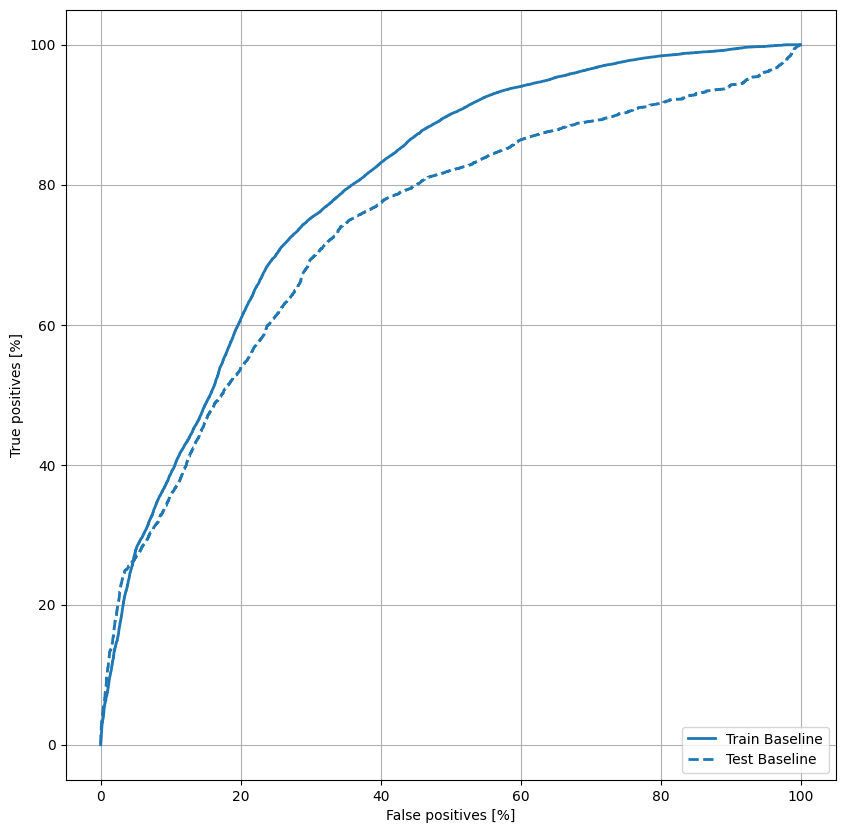

In [15]:


##################################### models, balancing, set division ##################################################################################


#set_original = [ ['mlp','original','data','False'], ['svm','original','data','False'], ['lstm','original','data','False'],['transformers','original','data','False']]
#set_original_2 = [ ['mlp','original','data','True'], ['svm','original','data','True'], ['lstm','original','data','True'],['transformers','original','data','True']]
#set_undersampling = [ ['mlp','undersampling','data','True'], ['svm','undersampling','data','True'], ['lstm','undersampling','data','True'],['transformers','undersampling','data','True']]
#set_oversampling = [ ['mlp','oversampling','data','True'], ['svm','oversampling','data','True'], ['lstm','oversampling','data','True'],['transformers','oversampling','data','True']]
#set_smote = [ ['mlp','smote','data','True'], ['svm','smote','data','True'], ['lstm','smote','data','True'],['transformers','smote','data','True']]

##################################### sets ##################################################################################################################

#all dataset
#date_chronological_all = ["2010-05-03 00:00:00", "2014-10-26 00:12:00", "2014-10-26 00:24:00", "2015-09-26 10:00:00", "2015-09-26 11:00:00", "2023-02-15 15:24:00"]

#date A1 - 2010-2011
#date_chronological_A1 = ["2010-05-03 00:00:00", "2010-10-31 23:59:59", "2011-06-01 00:00:00", "2011-12-31 23:59:59", "2010-11-01 00:00:00", "2011-01-31 23:59:59", "2011-02-21 00:00:00", "2011-05-31 23:59:59"]

#date A2 - 2012 - 2013
#date_chronological_A2 = ["2012-01-01 00:00:00", "2012-08-31 23:59:59", "2013-07-01 00:00:00", "2014-08-31 23:59:59", "2012-09-01 00:00:00", "2013-01-31 23:59:59", "2013-02-01 00:00:00", "2013-06-30 23:59:59"]

#date A3  - 2014-2016
#date_chronological_A3 = ["2014-09-01 00:00:00", "2015-03-31 23:59:59", "2015-10-01 00:00:00", "2016-06-30 23:59:59", "2015-04-01 00:00:00", "2015-06-30 23:59:59", "2015-07-01 00:00:00", "2015-09-30 23:59:59"]

#date A4 - 2016-2018
#date_chronological_A4 = ["2016-07-01 00:00:00", "2017-02-28 23:59:59", "2017-09-01 00:00:00", "2018-07-31 23:59:59", "2017-03-01 00:00:00", "2017-05-31 23:59:59", "2017-06-01 00:00:00", "2017-08-31 23:59:59"]

    
##################################### SHARP parameters ##################################################################################

#all_sharp_parameters =['DATE','DATE_S','DATE_B','DATE__OBS','DATE-OBS','T_OBS','T_REC_formatado','Class_2','class_flare','Ano','TOTUSJH','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP','USFLUX','AREA_ACR','MEANPOT','R_VALUE','SHRGT45','MEANGAM','MEANGBT','MEANGBZ','MEANSHR','MEANGBH','MEANJZH','MEANJZD','MEANALP']
#18_sharp_parameters = ['DATE','DATE_S','DATE_B','DATE__OBS','DATE-OBS','T_OBS','T_REC_formatado','Class_2','class_flare','Ano']
#10_sharp_parameters = ['DATE','DATE_S','DATE_B','DATE__OBS','DATE-OBS','T_OBS','T_REC_formatado','Class_2','class_flare','Ano','MEANGAM','MEANGBT','MEANGBZ','MEANSHR','MEANGBH','MEANJZH','MEANJZD','MEANALP']




#set variables
results_file = 'dados/results.csv'
data_file = "data/2010-2023-03-abcmx.csv"
separator_file = ";"
date_chronological = []

set_balancing = [ ['mlp','smote','data','True'], ['svm','smote','data','True'], ['lstm','smote','data','True'],['transformers','smote','data','True']]

list_col_delete = ['DATE','DATE_S','DATE_B','DATE__OBS','DATE-OBS','T_OBS','T_REC_formatado','Class_2','class_flare','Ano']

date_chronological = ["2010-05-03 00:00:00", "2014-10-26 00:12:00", "2014-10-26 00:24:00", "2015-09-26 10:00:00", "2015-09-26 11:00:00", "2023-02-15 15:24:00"]


with open(results_file, 'w') as csvfile:
    #write head
    csv.writer(csvfile, delimiter=';').writerow(['Model','Balancing','DivisionSets','Weights','TP', 'FP', 'TN', 'FN', 'ACC', 'PRE', 'Recall', 'HSS', 'TSS', 'AUC', 'ROC', 'FAR', 'LOSS'])
 
    #write results
    for i in range(4):
        csv.writer(csvfile, delimiter=';').writerow(train_models(set_balancing[i][0], set_balancing[i][1], set_balancing[i][2], set_balancing[i][3],list_col_delete,date_chronological, separator_file))

  